# Baseline implementation
This notebook implement the prediction of hypotension using the last mean artrial pressure (MAP) value. It is use as a baseline to compare with other models.

In [5]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from hp_pred.experiments import bootstrap_test, load_labelized_cases, get_all_stats, print_statistics

In [6]:
FEATURE_NAME = "last_map_value"
rng_seed = 42

In [7]:
# import the data frame and add the meta data to the segments
data = pd.read_parquet('data/datasets/base_dataset/cases/')
static = pd.read_parquet('data/datasets/base_dataset/meta.parquet')
data = data.merge(static, on='caseid')

#get columns name with _0 and rename them with _10
data = data.rename(columns={col: col.replace('_0', '_10') for col in data.columns if '_0' in col})

data.asa = data.asa.astype(int)
data.preop_htn = data.preop_htn.astype(int)

train = data[data['split'] == "train"]
test = data[data['split'] == "test"]

In [8]:
# for each subgoup of data, create a regressor and evaluate it
n_bootstraps = 200
rng_seed = 42  # control reproducibility
rng = np.random.RandomState(rng_seed)

# create a regressor
print(f"test set contains {len(test)} sample with a prevalence of {test['label'].mean()*100:.2f}% ")
print(f"train set contains {len(train)} sample with a prevalence of {train['label'].mean()*100:.2f}%")

test = test.dropna(subset=[FEATURE_NAME])

x_test = test[FEATURE_NAME].values
y_test = test['label'].values
y_pred = 1 - x_test/120
y_label_id = test["label_id"].values


df_results, tpr_list, precision_list = bootstrap_test(y_test, y_pred, y_label_id, n_bootstraps=n_bootstraps, rng_seed=rng_seed, strategy='max_precision')

result_folder = Path("data/results")
if not result_folder.exists():
    result_folder.mkdir()
roc_results = result_folder / "baseline_results.csv"
df_results.to_csv(roc_results, index=False)



test set contains 71522 sample with a prevalence of 8.31% 
train set contains 169821 sample with a prevalence of 7.67%


100%|██████████| 200/200 [02:22<00:00,  1.40it/s]


In [9]:
print_statistics(df_results)
print((1 - df_results['threshold_opt'].iloc[-1])*120)
print((1 - df_results['threshold_opt'].iloc[-1])*120 - (1 - df_results['threshold_opt'].iloc[-1] - df_results['threshold_opt_std'].iloc[-1])*120)

AUC: 67.4% ± 0.4%
AP: 17.4% ± 0.4%
AUPRC: 20.3% ± 0.5%
Threshold: 0.45 ± 0.00
Recall: 15.2% ± 1.0%
Precision: 30.9% ± 1.6%
Specificity: 84.4% ± 1.3%
NPV: 98.8% ± 0.0%
F1-score: 0.20 ± 0.01
66.24969363212585
0.1361252598331646


<Figure size 1200x500 with 0 Axes>

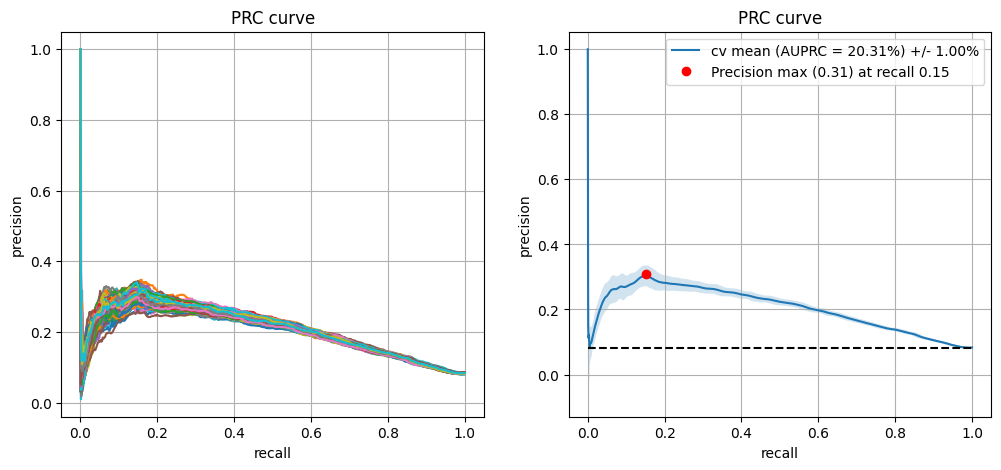

In [10]:
# PRC curves
plt.figure(figsize=(12, 5))

recall = np.linspace(0, 1, 1000)
# plot the ROC curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i in range(len(precision_list)):
    plt.plot(recall, precision_list[i])
# plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('PRC curve')
plt.grid()

plt.subplot(1, 2, 2)

plt.fill_between(recall, df_results['precision'] - 2*df_results['precision_std'], df_results['precision'] + 2*df_results['precision_std'], alpha=0.2)
plt.plot(recall, df_results['precision'], label=f"cv mean (AUPRC = {df_results['auprc'][0]:.2%}) +/- {2*df_results['auprc_std'][0]:.2%}")
plt.plot([0, 1], [df_results['precision'].iloc[-1]]*2, 'k--')
plt.plot([df_results['recall_threshold'].iloc[-1]], [df_results['precision_threshold'].iloc[-1]], 'ro', label=f"Precision max ({df_results['precision_threshold'].iloc[-1]:.2f}) at recall {df_results['recall_threshold'].iloc[-1]:.2f}")
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('PRC curve')
plt.legend()
plt.grid()
plt.show()

In [11]:
# plot 3 random cases with the corresponding decision function
np.random.seed(12)
cases = np.random.choice(test['caseid'].unique(), 3, replace=False)

for case in cases:
    
    raw_case = load_labelized_cases(dataset_path=Path('data/datasets/base_dataset_no_leading_time/'), caseid=case)

    segment_data = test[test['caseid'] == case]

    segment_data = segment_data.dropna(subset=[f'{FEATURE_NAME}_ema_{HALF_TIME_FILTERING}'])
    x_test = segment_data[f'{FEATURE_NAME}_ema_{HALF_TIME_FILTERING}'].values.reshape(-1, 1)
    y_test_case = segment_data['label'].values
    y_pred_case  = 1 - x_test/120

    plt.figure(figsize=(12, 5))
    plt.fill_between(raw_case.index.seconds/60, np.zeros(len(raw_case.index)), raw_case.label*raw_case['mbp'].max(), label='label', alpha=0.2)
    # FIX: NA values in mbp, missing fillna?
    plt.plot(raw_case.index.seconds/60, raw_case['mbp'])
    plt.hlines(65, raw_case.index.seconds[0]/60, raw_case.index.seconds[-1]/60, color='r', linestyle='--', label='IOH threshold')
    plt.plot(segment_data['time'] / np.timedelta64(1, 's') /60,y_pred_case *100, '.', label='model decision function')
    # plt.plot(segment_data['time']/60, segment_data[f'{FEATURE_NAME}_ema_{HALF_TIME_FILTERING}'], '*', label='label')
    plt.xlabel('Time (min)')
    # plt.xlim([97, 110])
    # plt.xlim([235, 245])
    # plt.ylim([42, 80])
    plt.legend()
    plt.title(f'Case {case}')
    plt.grid()
    plt.show()


KeyError: ['last_map_value_ema_10']